In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Conv2D,concatenate

from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer
# from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
# from keras.utils.vis_utils import plot_model
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob

c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\USER\anaconda3\envs\MNIST\lib\site-packages\tensorflow\python\frame

In [3]:
train_path="Dataset/Train"
test_path="Dataset/Test"
val_path="Dataset/Validation"

#train_path="/kaggle/input/autism-data/AutismDataset/train"
#test_path="/kaggle/input/autism-data/AutismDataset/test"
#val_path="/kaggle/input/autism-data/AutismDataset/valid"
train_datagen = ImageDataGenerator( 
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  ) 
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(  rescale=1./255.0)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'binary',
                                            shuffle=False)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'binary')

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [4]:
base_model = MobileNet(input_shape=(224, 224, 3),
                       weights = 'imagenet', 
                       include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
for layer in base_model.layers:
  layer.trainable=True
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()
#plot_model(model)
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau


#Defining a Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True,mode='auto')

# reduce_lr : val_loss 連續不降低時，減少learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto',
                            epsilon=0.0001, cooldown=0, min_lr=0)

checkpoint = ModelCheckpoint('MobileNet_tf1_v2.h5', monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
#Putting the call backs in a callback list
#callbacks = [checkpoint, reduce_lr]
callbacks = [checkpoint,early_stopping, reduce_lr]

In [17]:
history = model.fit(
    training_set,
    epochs=20,
    batch_size=64,
    validation_data=val_set,
    callbacks=[checkpoint,early_stopping, reduce_lr]
)

Epoch 1/20
  29/2188 [..............................] - ETA: 5:36:21 - loss: 0.6564 - acc: 0.6573

KeyboardInterrupt: 

In [9]:
def plot_training(hist):
    """
    visualize the training and validation performance of a machine learning model over epochs. 
    It plots two subplots
    1.training and validation loss 
    2. training and validation accuracy, 
    highlighting the epochs with the lowest validation loss and the highest validation accuracy
    """
    tr_acc = hist.history['acc']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

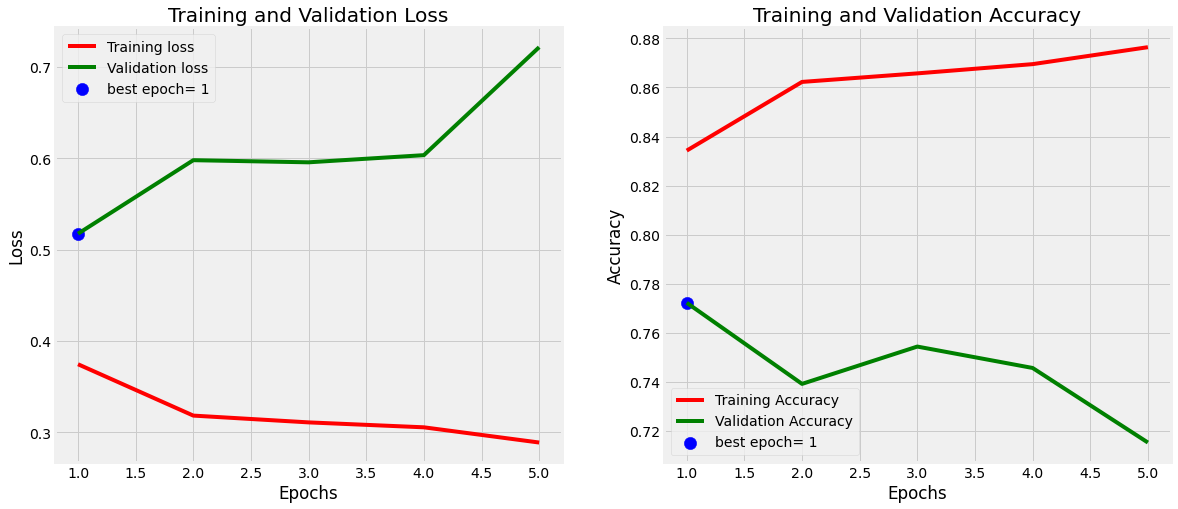

In [10]:
plot_training(history)

In [11]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

num_test_sample=len(test_set)
num_classes=len(test_set.class_indices)

predicted_probabilities=model.predict(test_set,steps=num_test_sample)
predicted_labels=np.argmax(predicted_probabilities,axis=1)

true_labels=test_set.classes

report=classification_report(true_labels,predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.48      0.61      5492
           1       0.63      0.90      0.74      5413

    accuracy                           0.69     10905
   macro avg       0.73      0.69      0.68     10905
weighted avg       0.73      0.69      0.68     10905

